## Learning Objectives

At the end of the experiment, you will be able to:

* explore the text data
* understand and perform text pre-processing
* build an LSTM model
* train the model on the IMDB reviews dataset

## Sentiment Classification

Sentiment classification is the automated process of identifying and classifying emotions in the text as positive sentiment, negative sentiment, or neutral sentiment based on the opinions expressed within. It helps determine the nature and extent of feelings conveyed using Natural Language Processing (NLP) to understand what customers say or feel about your brand, products, and services.

Manually reading, classifying, and sorting text data can take a long time. You can lose the essence of what's important when you get stuck manually analyzing and classifying positive and negative sentiments.

Sentiment classification has seen tremendous growth in recent years. Many businesses use it to better understand their customers' feelings, behavior, preferences, and needs.

Automated classification methods enable you to analyze reviews, comments, survey responses, and other public opinions faster. They analyze data to determine the overall tone toward your brand and products, as well as the broader industry and market trends and insights.

### Recurrent Neural Network (RNN)

## Dataset Description

The dataset used in this experiment is the [IMDB movie review](http://ai.stanford.edu/~amaas/data/sentiment/) dataset. This dataset for binary sentiment classification contains around 50k movie reviews with the following attributes:

* **review:** text based review of each movie
* **sentiment:** positive or negative sentiment value


### Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup          # BeautifulSoup is a useful library for extracting data from HTML and XML documents
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU
import pandas.testing as tm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load the Dataset

In [ ]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")

### Exploratory Data Analysis

In [ ]:
# Check the shape of the data
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Check for null Values
movie_reviews.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

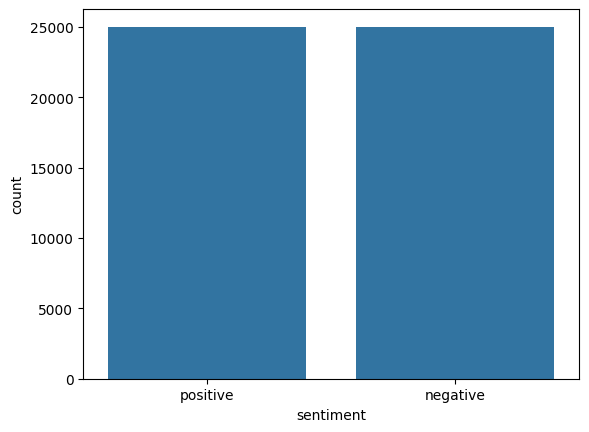

In [ ]:
# View the distribution of positive and negative sentiments in the dataset
sns.countplot(x='sentiment', data = movie_reviews)
plt.show()

We can see above that there are an equal number of positive and negative sentiment reviews in the dataset.

###Data Preprocessing

Remove any html tags, punctuations, special characters, stopwords etc. from the review text.

- **Remove HTML, XML, etc.**


In [ ]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
movie_reviews['review'] = movie_reviews['review'].apply(strip_html)

- **Remove punctuations**

In [ ]:
# removing punctuations
def remove_punctuations(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
# Remove puntuations
movie_reviews['review'] = movie_reviews['review'].apply(remove_punctuations)

**Removing stopwords**

Stopwords are English words that do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [ ]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

The above list of stopwords also contains the word "not", and its other forms such as don't, didn't, etc. We need them for correct sentiment classification.

For example, consider a negative review "*not a good movie*", and if we remove 'not' from it then it becomes a positive review "*a good movie*".

In [ ]:
# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'd', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs'

In [ ]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt_tab


      Unzipping tokenizers/punkt_tab.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
from nltk.tokenize import word_tokenize
print(word_tokenize("This is a test."))  # Should work now


['This', 'is', 'a', 'test', '.']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered)

# Apply to your DataFrame
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# # Import the NLTK library
# import nltk

# # Download the 'punkt_tab' resource
# nltk.download('punkt_tab')

# # setting english stopwords
# stopword_list = nltk.corpus.stopwords.words('english')
# print(stopword_list)

# # Exclude 'not' and its other forms from the stopwords list
# updated_stopword_list = []

# for word in stopword_list:
#     if word=='not' or word.endswith("n't"):
#         pass
#     else:
#         updated_stopword_list.append(word)

# print(updated_stopword_list)

# # removing the stopwords
# def remove_stopwords(text, is_lower_case=False):
#     # splitting strings into tokens (list of words)
#     tokens = nltk.tokenize.word_tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         # filtering out the stop words
#         filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
#     filtered_text = ' '.join(filtered_tokens)
#     return filtered_text

# # Apply function on review column
# movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [ ]:
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,Basically theres family little boy Jake thinks...,negative
4,Petter Matteis Love Time Money visually stunni...,positive


In [ ]:
# Convert sentiment labels to integers

movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically theres family little boy Jake thinks...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'].values, movie_reviews['sentiment'].values,
                                                    test_size=0.20,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

Prepare the Embedding Layer

The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras

In [ ]:
# Tokenizer class from the keras.preprocessing.text module creates a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

The X_train set contains 40,000 lists of integers, each list corresponding to the sentences in a review. Set the maximum length of each list to 100 and add 0 padding to those lists that have a length $\lt$100, until they reach a length of 100.

In [ ]:
# Find the vocabulary size and perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_pad = pad_sequences(X_train_tok, padding='post', maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_tok, padding='post', maxlen=maxlen, truncating='post')

In [ ]:
print ('number of unique words in the corpus:', vocab_size)

number of unique words in the corpus: 192115


### Build LSTM Model for Text classification

In [ ]:
EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Summary of the built model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Training and Validation

In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 480ms/step - accuracy: 0.6053 - loss: 0.6480 - val_accuracy: 0.6568 - val_loss: 0.6294
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 150s 517ms/step - accuracy: 0.6568 - loss: 0.6287 - val_accuracy: 0.6405 - val_loss: 0.6275
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 497ms/step - accuracy: 0.6455 - loss: 0.6260 - val_accuracy: 0.6475 - val_loss: 0.6197


### Model Performance

In [ ]:
print('Testing...')
y_test = np.array(y_test)
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6459 - loss: 0.6227
Test score: 0.6226854920387268
Test accuracy: 0.6467999815940857
Accuracy: 64.68%


### Predict a few more samples

In [ ]:
#Let us test some  samples
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

# predict
pred = model.predict(x=test_samples_tokens_pad)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


array([[0.5952101 ],
       [0.6004022 ],
       [0.59412366],
       [0.5791006 ],
       [0.5861051 ],
       [0.5922864 ],
       [0.6004022 ],
       [0.5746075 ]], dtype=float32)

The values close to 1 represents `positive` sentiment, and values close to 0 represents `negative` sentiment.